# Algorithm Outline
 1) Initialize grid, physical parameters, and field arrays for ψ (streamfunction) and ω (vorticity).
 2) Time-marching loop (for each time step):
    a) Solve Poisson equation ∇²ψ = -ω for ψ via Successive Over-Relaxation (SOR).
    b) Compute vorticity at the solid boundaries directly from ψ (using ω = -∇²ψ) and lid velocity.
    c) Advect and diffuse interior ω using the vorticity transport equation (explicit FTCS).
 3) After convergence or final time, post-process and plot vorticity and streamfunction.

## Import necessary libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D  # enables 3D plotting (not directly used here)
import numpy as np                      # numerical arrays and operations
import matplotlib.pyplot as plt         # plotting library

from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Operator, SparsePauliOp

from scipy.sparse import diags, eye, kron, identity, block_diag, csr_matrix

from classiq import *

authenticate()

c:\Users\Weidong\OneDrive - University of Calgary\Desktop\CFD\Quantum_Computing_Collaboration\.venv\Lib\site-packages\classiq\_internals\authentication\token_manager.py:101: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


## Define helper functions

In [2]:
# Function to build a sparse Poisson system using Kronecker sums
# Suitable for Pauli-string decomposition in quantum simulations
def build_sparse_discretized_poisson(nx, ny, dx):
    """
    Build the sparse Poisson system A ψ = b for a 2D grid.

    Parameters:
        nx (int): Number of grid points in the x-direction.
        ny (int): Number of grid points in the y-direction.
        dx (float): Grid spacing (assumed equal in x and y).
        omega (array_like): 2D array of vorticity values, shape (nx, ny).

    Returns:
        A (scipy.sparse.csr_matrix): Sparse matrix of shape (N, N),
            representing the 5-point Laplacian (∇²) scaled by 1/dx²,
            where N = nx * ny.  It enforces ∇²ψ = -ω.
            
        b (numpy.ndarray): 1D array of length N, the right-hand side
            vector with entries -ω[i,j] * dx^2, flattened in row-major order.
    """
    # Create 1D Laplacian matrices in x and y directions
    main_x = -2.0 * np.ones(nx)
    off_x  = 1.0  * np.ones(nx-1)
    Tx = diags([off_x, main_x, off_x], [-1, 0, 1], format='csr')
    main_y = -2.0 * np.ones(ny)
    off_y  = 1.0  * np.ones(ny-1)
    Ty = diags([off_y, main_y, off_y], [-1, 0, 1], format='csr')
    # Identity matrices
    Ix = eye(nx, format='csr')
    Iy = eye(ny, format='csr')
    # 2D Laplacian via Kronecker sum: A = I_y ⊗ T_x + T_y ⊗ I_x
    A = (kron(Iy, Tx, format='csr') + kron(Ty, Ix, format='csr')) / (dx*dx)
    # Right-hand side vector
    return A

# Example: printing the sparse matrix in dense form
# After building A as a CSR matrix you can use:
#    dense_A = A.toarray()        # convert to NumPy array

# Or use qiskit for better visualization
# from qiskit.visualization import array_to_latex
# display(array_to_latex(A.toarray()))

def get_b(omega, dx):
    b = -omega.flatten() * dx**2
    return b

def pad_to_power_of_two(
    A: csr_matrix | None   = None,
    b: np.ndarray  | None  = None
) -> csr_matrix | np.ndarray | tuple[csr_matrix, np.ndarray]:
    
    """
    Pad a sparse CSR matrix and/or vector to the next power-of-two dimension
    for qubit-based solvers.

    You may supply either:
      - A only  => returns padded A
      - b only  => returns padded b
      - A and b => returns (Apad, bpad)

    Parameters
    ----------
    A : scipy.sparse.csr_matrix, optional
        Original square matrix of shape (N, N).
    b : numpy.ndarray, optional
        Original right-hand side vector of length N.

    Returns
    -------
    Apad : scipy.sparse.csr_matrix
        Padded matrix of shape (2^n, 2^n) if A was provided.
    bpad : numpy.ndarray
        Padded RHS vector of length 2^n if b was provided.
    (Apad, bpad) : tuple
        If both A and b are given.
    """
    # Determine original size N
    if A is not None:
        N = A.shape[0]
    elif b is not None:
        b = np.asarray(b).flatten()
        N = b.shape[0]
    else:
        raise ValueError("Must provide at least one of A or b to pad.")

    # Compute next power of two ≥ N
    n_bits = (N - 1).bit_length()
    N2 = 1 << n_bits
    M = N2 - N

    # If already power-of-two, just return copy(s)
    if M == 0:
        if A is not None and b is not None:
            return A.copy(), b.copy()
        elif A is not None:
            return A.copy()
        else:
            return b.copy()

    # Build padding structures
    pad_id = identity(M, dtype=(A.dtype if A is not None else np.float64), format='csr')

    # Pad A if requested
    if A is not None:
        Apad = block_diag([A, pad_id], format='csr')
    # Pad b if requested
    if b is not None:
        bpad = np.empty(N2, dtype=b.dtype)
        bpad[:N] = b
        bpad[N:] = 0

    # Return according to inputs
    if A is not None and b is not None:
        return Apad, bpad
    elif A is not None:
        return Apad
    else:
        return bpad

## Set problem parameters

In [4]:

nx = 3       # number of grid points in x-direction
ny = 3       # number of grid points in y-direction
max_step = 200  # total number of time steps to march
visc = 0.1      # kinematic viscosity nu
u_wall = 1.0    # lid (top boundary) horizontal velocity

dt = 0.005      # time step size
dx = 1.0/(nx-1) # grid spacing (uniform) in both x and y

# === SOR (Successive Over-Relaxation) parameters for Poisson solver ===
max_iter = 100   # max iterations per time step for solving psi
beta = 1.5       # relaxation factor (>1 accelerates convergence)
max_err = 1e-3   # convergence tolerance for psi

# === Field arrays initialization ===
psi   = np.zeros((nx, ny))  # streamfunction array
omega = np.zeros((nx, ny))  # vorticity array
omega0 = np.zeros_like(omega)  # temporary array for previous vorticity
# coordinate arrays for plotting
x = np.zeros((nx, ny))
y = np.zeros((nx, ny))

# Fill coordinate arrays assuming domain [0,1]x[0,1]
for i in range(nx):
    for j in range(ny):
        x[i,j] = dx * i  # x-coordinate at grid index i
        y[i,j] = dx * j  # y-coordinate at grid index j

## SOR solver for Streamfunction, psi

In [5]:
def solve_streamfunction_sor(psi, omega, dx, beta, max_iter, max_err):
    """
    Solve ∇²ψ = –ω on the interior of a (nx×ny) grid by SOR in place.

    Parameters
    ----------
    psi : 2D ndarray, shape (nx,ny)
        Initial guess for the streamfunction.
    omega : 2D ndarray, shape (nx,ny)
        Current vorticity field (source term).
    dx : float
        Grid spacing (assumed equal in x and y).
    beta : float
        Relaxation factor (1<beta<2 for over–relaxation).
    max_iter : int
        Maximum number of SOR sweeps.
    tol : float
        Convergence tolerance on the L1 change in ψ.

    Returns
    -------
    psi : 2D ndarray
        Updated streamfunction (in place).
    iters : int
        Number of iterations actually performed.
    """
    nx, ny = psi.shape
    for it in range(1, max_iter + 1):
        psi_old = psi.copy()
        # Update interior points using SOR
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                # 5-point Laplacian + source term (vorticity)
                psi[i, j] = (
                    (1 - beta)*psi[i, j]
                    + (beta * 0.25) * (
                        psi[i+1, j] + psi[i-1, j]
                        + psi[i, j+1] + psi[i, j-1]
                        + dx*dx * omega[i, j]
                    )
                )
        # check convergence (L1 norm)
        err = np.sum(np.abs(psi - psi_old))
        if err < max_err:
            return psi, it, err
    return psi, max_iter, err

## Quantum solver for Streamfunction, psi

In [ ]:
# 1) Construct Ax = b. 

A = build_sparse_discretized_poisson(nx, ny, dx)
b = get_b(omega, dx)

Apad, bpad = pad_to_power_of_two(A, b)

# Normalize vector b
b_norm = bpad / np.linalg.norm(b) # Must go through 1 timestep, otherwise, b = 0.

A_norm = Apad.toarray()

@qfunc
def load_b(amplitudes: CArray[CReal], state: Output[QArray]) -> None:
    prepare_amplitudes(amplitudes, 0.0, state)




from classiq.qmod.symbolic import floor, log

# Parameters for the initial state preparation
amplitudes = b_norm.tolist()

# Parameters for the QPE
precision = 4


@qfunc
def hhl(
    rhs_vector: CArray[CReal],
    precision: CInt,
    hamiltonian_evolution_with_power: QCallable[CInt, QArray],
    state: Output[QArray],
    phase: Output[QNum],
    indicator: Output[QBit],
):
    # Allocate a quantum number for the phase with given precision
    allocate(precision, UNSIGNED, precision, phase)

    # Prepare initial state
    load_b(amplitudes=amplitudes, state=state)

    # Allocate indicator
    allocate(indicator)
    # Perform quantum phase estimation and eigenvalue inversion within a quantum operation
    within_apply(
        lambda: qpe_flexible(
            unitary_with_power=lambda k: hamiltonian_evolution_with_power(k, state),
            phase=phase,
        ),
        lambda: assign_amplitude((1 / 2**phase.size) / phase, indicator),
    )
    



def solve_x(A, b):
    """
    Obtain the solution vector x of size N.
    Recover psi[i,j] from x. 
    """
    ...

# 3) Update psi[i,j] from x. 

C:\Users\Weidong\AppData\Local\Temp\ipykernel_85692\2161571381.py:9: RuntimeWarning: invalid value encountered in divide
  b_norm = bpad / np.linalg.norm(b)


In [9]:
display(array_to_latex(Apad.toarray()))

<IPython.core.display.Latex object>

In [21]:
# Check if a csr_matrix is hermitian.

def is_hermitian_sparse(A: csr_matrix, tol=1e-10) -> bool:
    """
    Check if a scipy.sparse.csr_matrix is Hermitian (A = A†).
    
    Parameters:
        A (csr_matrix): Input sparse matrix.
        tol (float): Numerical tolerance for element-wise comparison.
    
    Returns:
        bool: True if A is Hermitian within the given tolerance.
    """
    if A.shape[0] != A.shape[1]:
        return False  # must be square
    
    diff = (A - A.getH()).tocoo()  # getH() is conjugate transpose
    return np.all(np.abs(diff.data) < tol)

print("Is our padded matrix, A, hermitian?")
is_hermitian_sparse(Apad)


Is our padded matrix, A, hermitian?


True

In [ ]:
A_norm = Apad.toarray()

<class 'numpy.ndarray'>


In [31]:
hamiltonian = matrix_to_hamiltonian(A_norm)
n = len(hamiltonian[0].pauli)

print("Pauli strings list: \n")
for pterm in hamiltonian:
    print(pterm.pauli, ": ", np.round(pterm.coefficient, 7))

print("\nNumber of qubits for matrix representation =", n)


Pauli strings list: 

[<Pauli.I: 0>, <Pauli.I: 0>, <Pauli.I: 0>, <Pauli.I: 0>] :  -8.5625
[<Pauli.I: 0>, <Pauli.I: 0>, <Pauli.I: 0>, <Pauli.Z: 3>] :  -1.0625
[<Pauli.I: 0>, <Pauli.I: 0>, <Pauli.Z: 3>, <Pauli.I: 0>] :  -1.0625
[<Pauli.I: 0>, <Pauli.I: 0>, <Pauli.Z: 3>, <Pauli.Z: 3>] :  -1.0625
[<Pauli.I: 0>, <Pauli.Z: 3>, <Pauli.I: 0>, <Pauli.I: 0>] :  -1.0625
[<Pauli.I: 0>, <Pauli.Z: 3>, <Pauli.I: 0>, <Pauli.Z: 3>] :  -1.0625
[<Pauli.I: 0>, <Pauli.Z: 3>, <Pauli.Z: 3>, <Pauli.I: 0>] :  -1.0625
[<Pauli.I: 0>, <Pauli.Z: 3>, <Pauli.Z: 3>, <Pauli.Z: 3>] :  -1.0625
[<Pauli.Z: 3>, <Pauli.I: 0>, <Pauli.I: 0>, <Pauli.I: 0>] :  -7.4375
[<Pauli.Z: 3>, <Pauli.I: 0>, <Pauli.I: 0>, <Pauli.Z: 3>] :  1.0625
[<Pauli.Z: 3>, <Pauli.I: 0>, <Pauli.Z: 3>, <Pauli.I: 0>] :  1.0625
[<Pauli.Z: 3>, <Pauli.I: 0>, <Pauli.Z: 3>, <Pauli.Z: 3>] :  1.0625
[<Pauli.Z: 3>, <Pauli.Z: 3>, <Pauli.I: 0>, <Pauli.I: 0>] :  1.0625
[<Pauli.Z: 3>, <Pauli.Z: 3>, <Pauli.I: 0>, <Pauli.Z: 3>] :  1.0625
[<Pauli.Z: 3>, <Pauli.Z: 3>, <P

## Time-marching loop

In [ ]:
# Time-marching loop
t_current = 0.0
for tstep in range(max_step):
    
    # ----- 1) Solve Poisson equation for streamfunction psi via SOR -----
    if tstep > 0:
      psi, sor_iters, err = solve_streamfunction_sor(
          psi, omega, dx, beta, max_iter, max_err)

    # ----- 2) Apply and calculate boundary vorticity at walls -----
    # Vorticity ω is computed at the walls directly from ψ (streamfunction) via ω = -∇²ψ,
    # with an extra term on the moving lid: ω = -2ψ/dx² - 2u_wall/dx for y = 1
    # This sets ω on the bottom, top, left and right boundaries.
    # bottom wall (y=0): u=0 => psi=0 => vorticity = -2*psi[...]/dx^2
    omega[1:nx-1, 0] = -2.0 * psi[1:nx-1, 1] / (dx*dx)
    # top lid (y=1): u=u_wall, psi=0 => includes lid velocity contribution
    omega[1:nx-1, ny-1] = -2.0 * psi[1:nx-1, ny-2] / (dx*dx) - 2.0 * u_wall / dx
    # left wall (x=0): psi=0
    omega[0, 1:ny-1] = -2.0 * psi[1, 1:ny-1] / (dx*dx)
    # right wall (x=1): psi=0
    omega[nx-1, 1:ny-1] = -2.0 * psi[nx-2, 1:ny-1] / (dx*dx)

    # ----- 3) Compute interior vorticity transport: advect + diffuse -----
    # Interior vorticity ω at each grid point is updated using the vorticity transport equation:
    # ∂ω/∂t + u ∂ω/∂x + v ∂ω/∂y = ν ∇²ω, discretized explicitly (FTCS).
    # Here ω0 holds the previous time step's vorticity.
    omega0[:] = omega  # store old vorticity
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            # compute convective term: u * d(omega)/dx + v * d(omega)/dy
            adv =  -0.25 * (
                    (psi[i,j+1] - psi[i,j-1]) * (omega0[i+1,j] - omega0[i-1,j])
                  - (psi[i+1,j] - psi[i-1,j]) * (omega0[i,j+1] - omega0[i,j-1])
                ) / (dx*dx)
            # diffusion term: nu * Laplacian(omega)
            diff = visc * (
                    omega0[i+1,j] + omega0[i-1,j]
                    + omega0[i,j+1] + omega0[i,j-1]
                  - 4.0 * omega0[i,j]
                ) / (dx*dx)
            # update vorticity explicitly
            omega[i,j] = omega0[i,j] + dt * (adv + diff)

    t_current += dt  # advance physical time

## Post-processing: plot results

Converged psi error: 6.25e-04


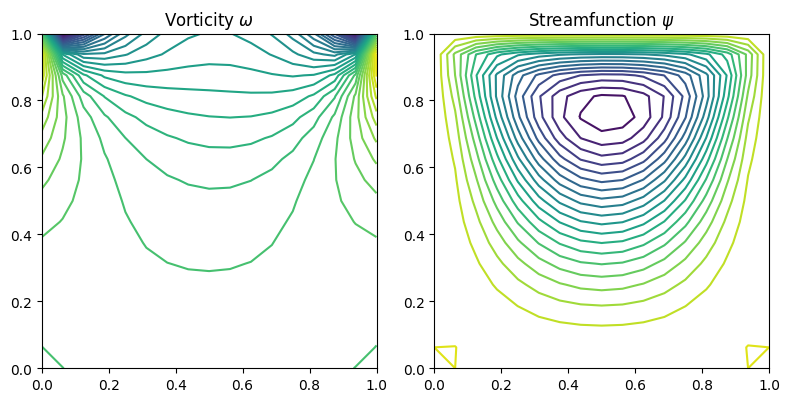

In [30]:

print(f"Converged psi error: {err:.2e}")
# Plot vorticity and streamfunction side-by-side
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.contour(x, y, omega, 40)
plt.title(r"Vorticity $\omega$")
plt.axis('square')

plt.subplot(1,2,2)
plt.contour(x, y, psi, 20)
plt.title(r"Streamfunction $\psi$")
plt.axis('square')

plt.tight_layout()
plt.show()